In [2]:
!pip install qiskit_optimization
!pip install qiskit_algorithms
!pip install qiskit_aer

In [3]:
!pip install qiskit.opflow

ERROR: Could not find a version that satisfies the requirement qiskit.opflow (from versions: none)
ERROR: No matching distribution found for qiskit.opflow


In [2]:
from qiskit_optimization import QuadraticProgram
import re

def qubo_from_expression(expression: str) -> QuadraticProgram:
    # Initialize the quadratic program
    mod = QuadraticProgram("QUBO Problem")

    # Parse variables from the expression using regex
    variables = list(set(re.findall(r'\b[a-zA-Z]\b', expression)))
    for var in sorted(variables):
        mod.binary_var(name=var)

    # Initialize terms
    constant = 0
    linear_terms = {}
    quadratic_terms = {}

    # Regex patterns for terms
    # Matches quadratic terms like "2*x*y" or "x*y"
    quadratic_pattern = re.compile(r"([+-]?\d*\.?\d*)\*?([a-zA-Z])\*([a-zA-Z])")
    # Matches linear terms like "2*x" or "x"
    linear_pattern = re.compile(r'([+-]?\d*\.?\d*)\*?([a-zA-Z])\b')
    # Matches constant terms like "3" or "-4"
    constant_pattern = re.compile(r'([+-]?\d+\.?\d+)\b')

    # Remove whitespace
    expression = expression.replace(" ", "")

    # Parse quadratic terms
    for match in quadratic_pattern.findall(expression):
        coef = float(match[0]) if match[0] not in ["", "+", "-"] else (-1 if match[0] == "-" else 1)
        var1, var2 = match[1], match[2]
        term = tuple(sorted([var1, var2]))  # Ensure consistent ordering
        quadratic_terms[term] = quadratic_terms.get(term, 0) + coef

    # Remove quadratic terms from expression to avoid double counting
    expression = quadratic_pattern.sub("", expression)

    # Parse linear terms
    for match in linear_pattern.findall(expression):
        coef = float(match[0]) if match[0] not in ["", "+", "-"] else (-1 if match[0] == "-" else 1)
        var = match[1]
        linear_terms[var] = linear_terms.get(var, 0) + coef

    # Remove linear terms from expression
    expression = linear_pattern.sub("", expression)

    # Parse constants
    for match in constant_pattern.findall(expression):
        constant += float(match)

    # Add the parsed terms to the quadratic program
    mod.minimize(constant=constant, linear=linear_terms, quadratic=quadratic_terms)

    return mod


import re

def extract_qubo_edges(expression):
    """
    Extracts QUBO edges and their weights from a given expression.
    Linear terms are interpreted as quadratic (e.g., 2*a -> 2*a*a).
    Missing coefficients are assumed to be 1.

    Args:
        expression (str): The QUBO expression as a string.

    Returns:
        list: A list of tuples representing edges in the form (node1, node2, weight).
    """
    # Remove whitespace
    expression = expression.replace(" ", "")

    # Match terms of the form "coefficient*var1*var2" or "coefficient*var" (linear terms)
    term_pattern = r"([+-]?\d*\.?\d*)\*?([a-zA-Z])(?:\*([a-zA-Z]))?"
    matches = re.findall(term_pattern, expression)

    # Convert matches to edge tuples
    edges = []
    for coeff, var1, var2 in matches:
        # Handle missing coefficient (e.g., "a*b" -> "1*a*b")
        if coeff in ('', '+', '-'):
            coeff = coeff + "1"  # Add "1" to missing coefficient (+ -> +1, - -> -1)
        weight = float(coeff)

        # If var2 is empty, it's a linear term, interpret as quadratic (var1*var1)
        if not var2:
            edges.append((var1, var1, weight))
        else:
            edges.append((var1, var2, weight))

    return edges

In [3]:
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer

expression_1 = "x + 2*x*y - z*z + 3"
expression_2 = "x*y + z*z - 2*x*z + 3*x*x - 1"
expression_3 ="- a*b + 2*b*c - c*d + d*e - 2*a*a + 1.5*b + 1.5"
expression_4 = "2*a*b - 3*b*c - 1.5*c*d + 4*d*e + e*f + 2.5*f*g + 3.5*g*h + 0.5*h*i + 2*i*j + j*a" # 2-regular, no triangles
expression_5 = "2*a*b - 3*b*c + 1.5*c*d + 4*d*e + e*f + 2.5*f*g + 3*g*h + 0.5*h*i + 2*i*j + j*a" # 2-regular, no triangles
expression_6 = "96*a*a + 192*a*b + 96*a*c + 96*a*x + 192*a*y \
  + 96*a*z + 192*a*v + 96*a*d - 100*a*q \
  - 100*a*p + 96*b*b + 96*b*c + 96*b*x + 192*b*y \
  + 96*b*z + 192*b*v + 96*b*d - 100*b*q \
  - 100*b*p + 48*c*c + 96*c*x + 192*c*y \
  - 100*c*q + 48*x*x + 192*x*y \
  + 192*y*x + 48*z*z \
  + 192*z*v + 192*v*v \
  + 96*d*z + 192*d*v + 48*d*d - 100*d*p \
  - 96*q*x - 192*q*y + 48*q*q \
  - 96*p*z - 192*p*v + 48*p*p - 384*a \
  - 384*b - 192*c - 192*x - 384*y - 192*z \
  - 384*v - 192*d + 202*q + 205*p + 384" # with triangles

exp = expression_2

qubo = qubo_from_expression(exp)
print(qubo.prettyprint())


exact_mes = NumPyMinimumEigensolver()
exact = MinimumEigenOptimizer(exact_mes)
exact_result = exact.solve(qubo)
for sample in exact_result.samples:
    print(sample)

print("Objective function value: ", exact_result.fval)
print("Number of solutions: ", len(exact_result.samples))

Problem name: QUBO Problem

Minimize
  3*x^2 + x*y - 2*x*z + z^2

Subject to
  No constraints

  Binary variables (3)
    x y z

SolutionSample(x=array([0., 0., 0.]), fval=0.0, probability=1.0, status=<OptimizationResultStatus.SUCCESS: 0>)
Objective function value:  0.0
Number of solutions:  1


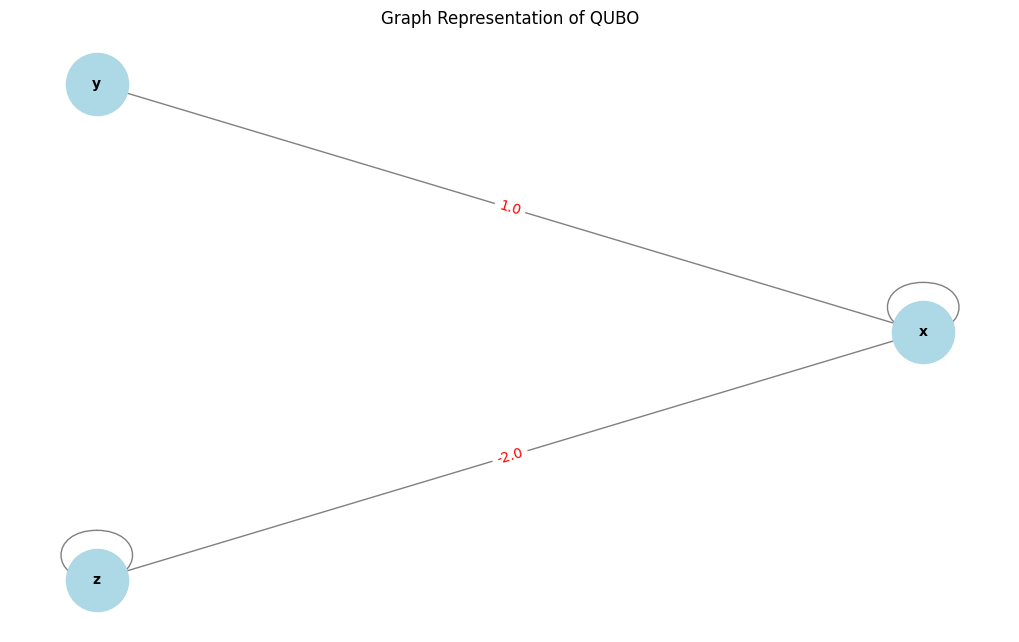

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

# Define the QUBO interactions as a weighted graph
qubo_edges = extract_qubo_edges(exp)
# Create a graph
G = nx.Graph()
G.add_weighted_edges_from(qubo_edges)

# Draw the graph
plt.figure(figsize=(10, 6))
pos = nx.circular_layout(G)  # Positioning nodes with spring layout
nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=2000, font_size=10, font_weight='bold')
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=10)
plt.title("Graph Representation of QUBO")
plt.show()


In [9]:
from qiskit_algorithms import QAOA
from qiskit_aer.primitives import Sampler
from qiskit_algorithms.optimizers import COBYLA, SPSA, ADAM, NELDER_MEAD, L_BFGS_B
from qiskit_optimization.algorithms import OptimizationResultStatus, SolutionSample
import numpy as np
from typing import List, Tuple

from qiskit.quantum_info import Pauli, SparsePauliOp



def get_beta_gamma_sequential(n, beta, gamma):
    return [beta] * n + [gamma] * n

def get_beta_gamma_alternating(n, beta, gamma):
    return [beta, gamma] * n

def step(step:int,params:np.array,mean:float,error:float):
    print(f'step: {step}, mean: {mean}, params: {params}')

def find_greatest_absolute_weight(qubo):
    weight_dict = qubo.objective.quadratic.to_dict() | qubo.objective.linear.to_dict()
    weights = weight_dict.values()
    return max(abs(weight) for weight in weights)

def get_beta(a, d):
    return (1/a)*np.arctan(1/np.sqrt(d-1))

qaoa_p = 7 #len(qubo.variables)

greatest_weight = find_greatest_absolute_weight(qubo)
beta = get_beta(greatest_weight, 2)

beta_gamma = get_beta_gamma_alternating(qaoa_p, 0, np.pi/8)

shots = 10000
sampler = Sampler(run_options={
        "shots": shots,
        "seed": 42,
        "max_parallel_threads": 0,
        "max_parallel_experiments": 0,
        "max_parallel_shots": 1,
        "statevector_parallel_threshold": 8,
        "device": "CPU"
    })
optimizer = COBYLA(maxiter=2500, tol=1e-4)

mixer_op = SparsePauliOp(["XXXXXXXXXX", "YYYYYYYYYY"], coeffs = [.5, .5])   #if we want to define a different mixer operator

qaoa_mes = QAOA(sampler=sampler, optimizer=optimizer, reps=qaoa_p, #callback=step,
               initial_point=beta_gamma)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qubo)

solutions = [s for s in result.samples if s.fval == result.fval]
for solution in solutions:
    print(solution)

print("Objective function value: ", solution.fval)
print("Number of solutions: ", len(solutions))


SolutionSample(x=array([0., 1., 0.]), fval=0.0, probability=0.5159, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 0.]), fval=0.0, probability=0.3535, status=<OptimizationResultStatus.SUCCESS: 0>)
Objective function value:  0.0
Number of solutions:  2


Total variables:  3
P:  7
Shots:  10000


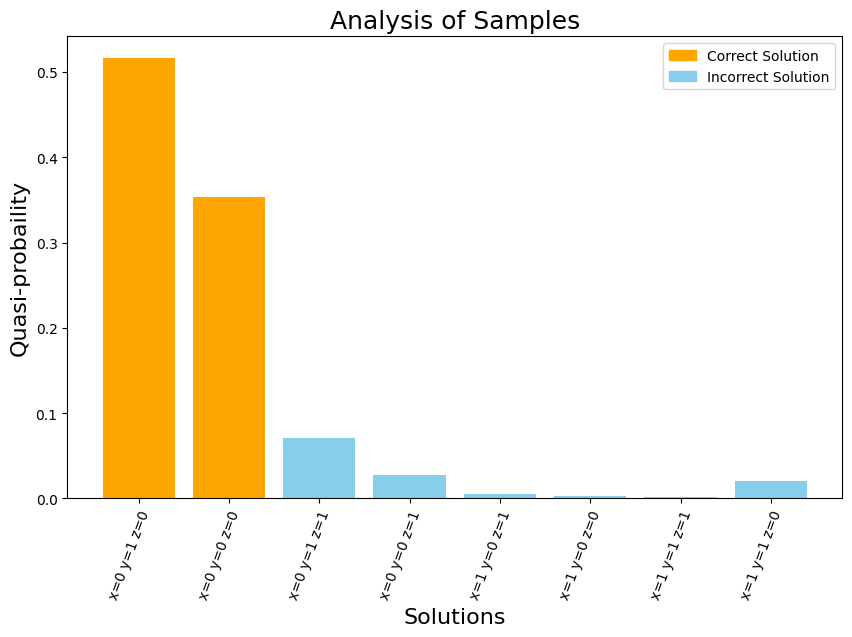

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def get_solutions_for_plot(result):
    solutions = []
    fval = result.fval
    for sample in result.samples:
        if sample.fval == fval:
            solutions.append(sample)
    return {
    " ".join(f"{result.variables[i].name}={int(v)}" for i, v in enumerate(s.x))
    for s in solutions
    }

def get_samples(data):
    return {
    " ".join(f"{data.variables[i].name}={int(v)}" for i, v in enumerate(s.x)): s.probability
    for s in data.samples
    }

solutions_for_plot = get_solutions_for_plot(result)
samples_for_plot = get_samples(result)

labels = list(samples_for_plot.keys())
values = list(samples_for_plot.values())

# Define color scheme, with one bar having a different color
colors = ['orange' if label in solutions_for_plot else 'skyblue' for label in labels]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=colors)

# Labeling
plt.xlabel("Solutions", fontsize=16)
plt.ylabel("Quasi-probaility", fontsize=16)
plt.title("Analysis of Samples", fontsize=18)
plt.xticks(rotation=70, ha='right', rotation_mode='anchor')  # Rotate x-axis labels for readability

# Create custom legend
correct_patch = mpatches.Patch(color='orange', label='Correct Solution')
incorrect_patch = mpatches.Patch(color='skyblue', label='Incorrect Solution')
plt.legend(handles=[correct_patch, incorrect_patch])

print("Total variables: ", len(result.variables))
print("P: ",qaoa_p)
print("Shots: ",shots)
plt.show()